# BCG Task 2 Feature Engineering & Modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category= FutureWarning)

In [ ]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [ ]:
df.shape

(14606, 44)

---

# Feature engineering

### Difference between off-peak prices in December and preceding January


In [ ]:
price_df = pd.read_csv('/content/price_data (1).csv')
price_df['price_date']= pd.to_datetime(price_df['price_date'], format='%Y-%m-%d')
price_df.head()


id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [ ]:
# Group off-peak prices by companies and month

monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var':'mean', 'price_off_peak_fix':'mean'}).reset_index()

In [ ]:
# Getting jan and dec prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

In [ ]:
# Calculating the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                        -0.010018   
4  00114d74e963e47177db89bc70108537                        -0.003994   

   offpeak_diff_dec_january_power  
0                        0.162916  
1                        0.177779  
2                        1.500000  
3                        0.162916  
4                       -0.000001

In [ ]:
df = pd.merge(df, diff, on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   
3      2010-03-30   2015-03-31             240.04  ...   
4      2010-01-13   2015-03-09             445.75  ...   

   var_6m_price_mid_peak_var  var_6m_price_off_peak_fix  \
0               9.084737e-04                   2.086294   
1               0.000000e+00                   0.009482   
2               0.000000e+00                   0.000000   
3               0.000000e+00                   0.000000   
4               4.860000e-10                   0.000000   

   var_6m_price_peak_fix  var_6m_price_mid_peak_fix  var_6m_price_off_peak  \
0              99.530517                  44.235794               2.086425   
1               0.000000                   0.000000               0.009485   
2               0.000000                   0.000000               0.000004   
3               0.000000                   0.000000               0.000003   
4               0.000000                   0.000000               0.000011   

   var_6m_price_peak var_6m_price_mid_peak  churn  \
0       9.953056e+01          4.423670e+01      1   
1       1.217891e-03          0.000000e+00      0   
2       9.450150e-08          0.000000e+00      0   
3       0.000000e+00          0.000000e+00      0   
4       2.896760e-06          4.860000e-10      0   

   offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  
0                         0.020057                        3.700961  
1                        -0.003767                        0.177779  
2                        -0.004670                        0.177779  
3                        -0.004547                        0.177779  
4                        -0.006192                        0.162916  

[5 rows x 46 columns]

---

## Average price changes across periods

We can now enhance the feature that our colleague made by calculating the average price changes across individual periods, instead of the entire year.

In [ ]:
# Aggregate average prices per period by company

mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [ ]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [ ]:
columns = [
    'id',
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff',
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff',
    'peak_mid_peak_fix_mean_diff',
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  var_6m_price_mid_peak  \
0      2015-11-01   2015-06-23               0.00  ...           4.423670e+01   
1      2009-08-21   2015-08-31             189.95  ...           0.000000e+00   
2      2010-04-16   2015-04-17              47.96  ...           0.000000e+00   
3      2010-03-30   2015-03-31             240.04  ...           0.000000e+00   
4      2010-01-13   2015-03-09             445.75  ...           4.860000e-10   

   churn  offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  \
0      1                         0.020057                        3.700961   
1      0                        -0.003767                        0.177779   
2      0                        -0.004670                        0.177779   
3      0                        -0.004547                        0.177779   
4      0                        -0.006192                        0.162916   

   off_peak_peak_var_mean_diff  peak_mid_peak_var_mean_diff  \
0                     0.024038                     0.034219   
1                     0.142485                     0.007124   
2                     0.082090                     0.088421   
3                     0.151210                     0.000000   
4                     0.020536                     0.030773   

  off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                        0.058257                    18.590255   
1                        0.149609                    44.311375   
2                        0.170512                    44.385450   
3                        0.151210                    44.400265   
4                        0.051309                    16.275263   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  
0                     7.450670                        26.040925  
1                     0.000000                        44.311375  
2                     0.000000                        44.385450  
3                     0.000000                        44.400265  
4                     8.137629                        24.412893  

[5 rows x 52 columns]

This feature may be useful because it adds more granularity to the existing feature that my colleague found to be useful. Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.


---

## Max price changes across periods and months

Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

In [ ]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [ ]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [ ]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [ ]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   
3      2010-03-30   2015-03-31             240.04  ...   
4      2010-01-13   2015-03-09             445.75  ...   

   off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                         0.058257                    18.590255   
1                         0.149609                    44.311375   
2                         0.170512                    44.385450   
3                         0.151210                    44.400265   
4                         0.051309                    16.275263   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                     7.450670                        26.040925   
1                     0.000000                        44.311375   
2                     0.000000                        44.385450   
3                     0.000000                        44.400265   
4                     8.137629                        24.412893   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                            0.060550                            0.085483   
1                            0.151367                            0.085483   
2                            0.084587                            0.089162   
3                            0.153133                            0.000000   
4                            0.022225                            0.033743   

  off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                               0.146033                           44.266930   
1                               0.151367                           44.444710   
2                               0.172468                           44.444710   
3                               0.153133                           44.444710   
4                               0.055866                           16.291555   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                            8.145775                                44.26693  
1                            0.000000                                44.44471  
2                            0.000000                                44.44471  
3                            0.000000                                44.44471  
4                            8.145775                                24.43733  

[5 rows x 58 columns]

I thought that calculating the maximum price change between months and time periods would be a good feature to create because I was trying to think from the perspective of a PowerCo client. As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal. Since we are trying to predict churn for this use case, I thought this would be an interesting feature to include.


# Tenure

How long a company has been a client of PowerCo.


In [ ]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'W')).astype(int)


In [ ]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

churn
tenure       
148       1.0
446       1.0
139       1.0
476       1.0
600       1.0
...       ...
359       0.0
360       0.0
362       0.0
363       0.0
685       0.0

[373 rows x 1 columns]

We can see that companies who have only been a client for 4 or less months are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer.

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

### Transforming dates into months

- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [ ]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [ ]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Function to calculate month difference
def calculate_month_difference(date1, date2):
    """
    Calculates the difference in months between two dates.
    """
    return (date1.year - date2.year) * 12 + (date1.month - date2.month)

# Create columns by applying the function to each row
df['months_activ'] = df['date_activ'].apply(lambda x: calculate_month_difference(reference_date, x))
df['months_to_end'] = df['date_end'].apply(lambda x: -calculate_month_difference(reference_date, x))
df['months_modif_prod'] = df['date_modif_prod'].apply(lambda x: calculate_month_difference(reference_date, x))
df['months_renewal'] = df['date_renewal'].apply(lambda x: calculate_month_difference(reference_date, x))

Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power.

Using intuition, you could assume that a client who has been an active client of PowerCo for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile. Hence the addition of the `months_activ` feature.

As well as this, if we think from the perspective of a client with PowerCo, if you're coming toward the end of your contract with PowerCo your thoughts could go a few ways. You could be looking for better deals for when your contract ends, or you might want to see out your contract and sign another one. One the other hand if you've only just joined, you may have a period where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. So, I think `months_to_end` will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

My belief is that if a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. I believe this to be a positive sign, they are an engaged customer, and so I believe `months_modif_prod` will be an interesting feature to include because it shows the degree of how 'engaged' a client is with PowerCo.

Finally the number of months since a client last renewed a contract I believe will be an interesting feature because once again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason, I believe `months_renewal` will be a good feature to include.

In [ ]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0         0         54946                0               0.00   
1      4660             0                0             189.95   
2       544             0                0              47.96   
3      1584             0                0             240.04   
4      4425             0              526             445.75   

   forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
0                   0                       0.0                     1.78   
1                   0                       0.0                    16.27   
2                   0                       0.0                    38.72   
3                   0                       0.0                    19.83   
4                 526                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  peak_mid_peak_var_max_monthly_diff  \
0                        0.114481  ...                            0.085483   
1                        0.145711  ...                            0.085483   
2                        0.165794  ...                            0.089162   
3                        0.146694  ...                            0.000000   
4                        0.116900  ...                            0.033743   

   off_peak_mid_peak_var_max_monthly_diff off_peak_peak_fix_max_monthly_diff  \
0                                0.146033                          44.266930   
1                                0.151367                          44.444710   
2                                0.172468                          44.444710   
3                                0.153133                          44.444710   
4                                0.055866                          16.291555   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  \
0                            8.145775                                44.26693   
1                            0.000000                                44.44471   
2                            0.000000                                44.44471   
3                            0.000000                                44.44471   
4                            8.145775                                24.43733   

   tenure  months_activ  months_to_end  months_modif_prod months_renewal  
0     156            31              5                  2              7  
1     366            77              7                 77              5  
2     313            69              3                 69              9  
3     313            70              2                 70             10  
4     320            72              2                 72             10  

[5 rows x 59 columns]

# Transforming Boolean Data
We simply want to transform this column from being categorical to being a binary flag

In [ ]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1,0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

churn
has_gas          
0        0.100544
1        0.081856

If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.


### Transforming categorical data

A predictive model cannot accept categorical or `string` values, hence as a data scientist you need to encode categorical features into numerical representations in the most compact and discriminative way possible.

The simplest method is to map each category to an integer (label encoding), however this is not always appropriate beecause it then introduces the concept of an order into a feature which may not inherently be present `0 < 1 < 2 < 3 ...`

Another way to encode categorical features is to use `dummy variables` AKA `one hot encoding`. This create a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

#### channel_sales

In [ ]:
# Transform into categorical data type
df['channel_sales'] = df['channel_sales'].astype('category')

In [ ]:
# checking the number of categories within the columns
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.



In [ ]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   
3                    19.83                        0.146694   
4                   131.73                        0.116900   

   forecast_price_energy_peak  ...  tenure  months_activ  months_to_end  \
0                    0.098142  ...     156            31              5   
1                    0.000000  ...     366            77              7   
2                    0.087899  ...     313            69              3   
3                    0.000000  ...     313            70              2   
4                    0.100015  ...     320            72              2   

   months_modif_prod  months_renewal  channel_MISSING  \
0                  2               7            False   
1                 77               5             True   
2                 69               9            False   
3                 70              10            False   
4                 72              10             True   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

  channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   channel_usilxuppasemubllopkaafesmlibmsdf  
0                                     False  
1                                     False  
2                                     False  
3                                     False  
4                                     False  

[5 rows x 63 columns]

# Origin_Up

In [ ]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

#check the number of categories within the field
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

Similar to `channel_sales` the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.


In [ ]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   
3                    19.83                        0.146694   
4                   131.73                        0.116900   

   forecast_price_energy_peak  ...  months_modif_prod  months_renewal  \
0                    0.098142  ...                  2               7   
1                    0.000000  ...                 77               5   
2                    0.087899  ...                 69               9   
3                    0.000000  ...                 70              10   
4                    0.100015  ...                 72              10   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0            False                                     False   
1             True                                     False   
2            False                                     False   
3            False                                     False   
4             True                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                      True   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                        True  
1                                       False  
2                                       False  
3                                       False  
4                                       False  

[5 rows x 65 columns]

# Transforming Numerical Data
In the previous exercise we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called `parametric` models, and they typically assume that all variables are both independent and normally distributed.

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:
- Square root
- Cubic root
- Logarithm

to a continuous numeric column and you will notice the distribution changes. For this use case we will use the 'Logarithm' transformation for the positively skewed features.

<b>Note:</b> We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First I want to see the statistics of the skewed features, so that we can compare before and after transformation


In [ ]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.795000   
75%           1745.750000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14606.000000  
mean                     43.130056  
std                       4.485988  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

We can see that the standard deviation for most of these features is quite high.

In [ ]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df['cons_12m']+1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [ ]:
df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14606.000000  14606.000000     14606.000000       14606.000000   
mean       4.223939      0.779244         2.264646           2.962177   
std        0.884515      1.717071         1.769305           0.683592   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.754023      0.000000         0.000000           2.695477   
50%        4.149727      0.000000         2.899547           3.046836   
75%        4.610285      0.000000         3.529430           3.380716   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean             1.784610                  0.966726                 1.517203   
std              1.584986                  5.108289                 0.571481   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.235023   
50%              2.498311                  0.000000                 1.296555   
75%              3.242231                  0.000000                 2.120673   
max              5.243970                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14606.000000  
mean                     43.130056  
std                       4.485988  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.


<ipython-input-31-39b904e0cf27>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0], color='g')
<ipython-input-31-39b904e0cf27>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1], color='orange')
<ipython-

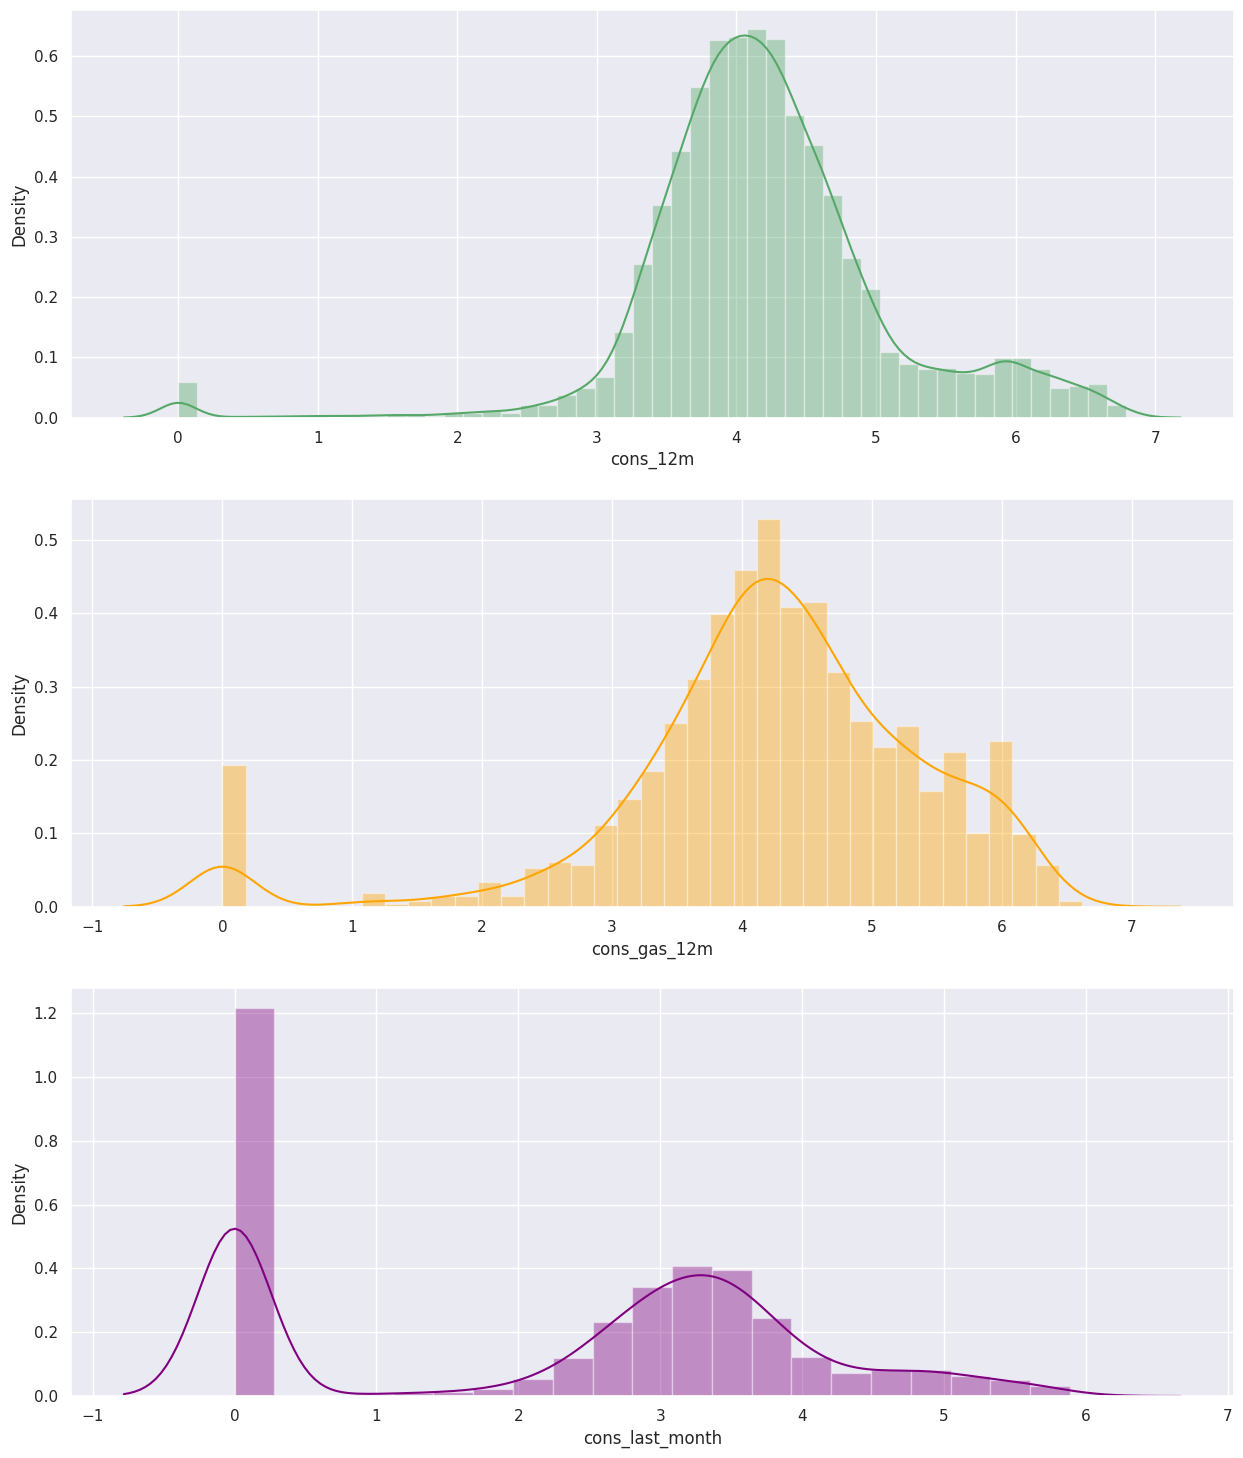

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 18))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0], color='g')
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1], color='orange')
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2], color='purple')

plt.show()

### Correlations

In terms of creating new features and transforming existing ones, it is very much a trial and error situation that requires iteration. Once we train a predictive model we can see which features work and don't work, we will also know how predictive this set of features is. Based on this, we can come back to feature engineering to enhance our model.

For now, we will leave feature engineering at this point. Another thing that is always useful to look at is how correlated all of the features are within your dataset.

This is important because it reveals the linear relationships between features. We want features to correlate with `churn`, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information. One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption.

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [ ]:

df_for_corr = df.drop(columns=['id'])
correlation = df_for_corr.corr()

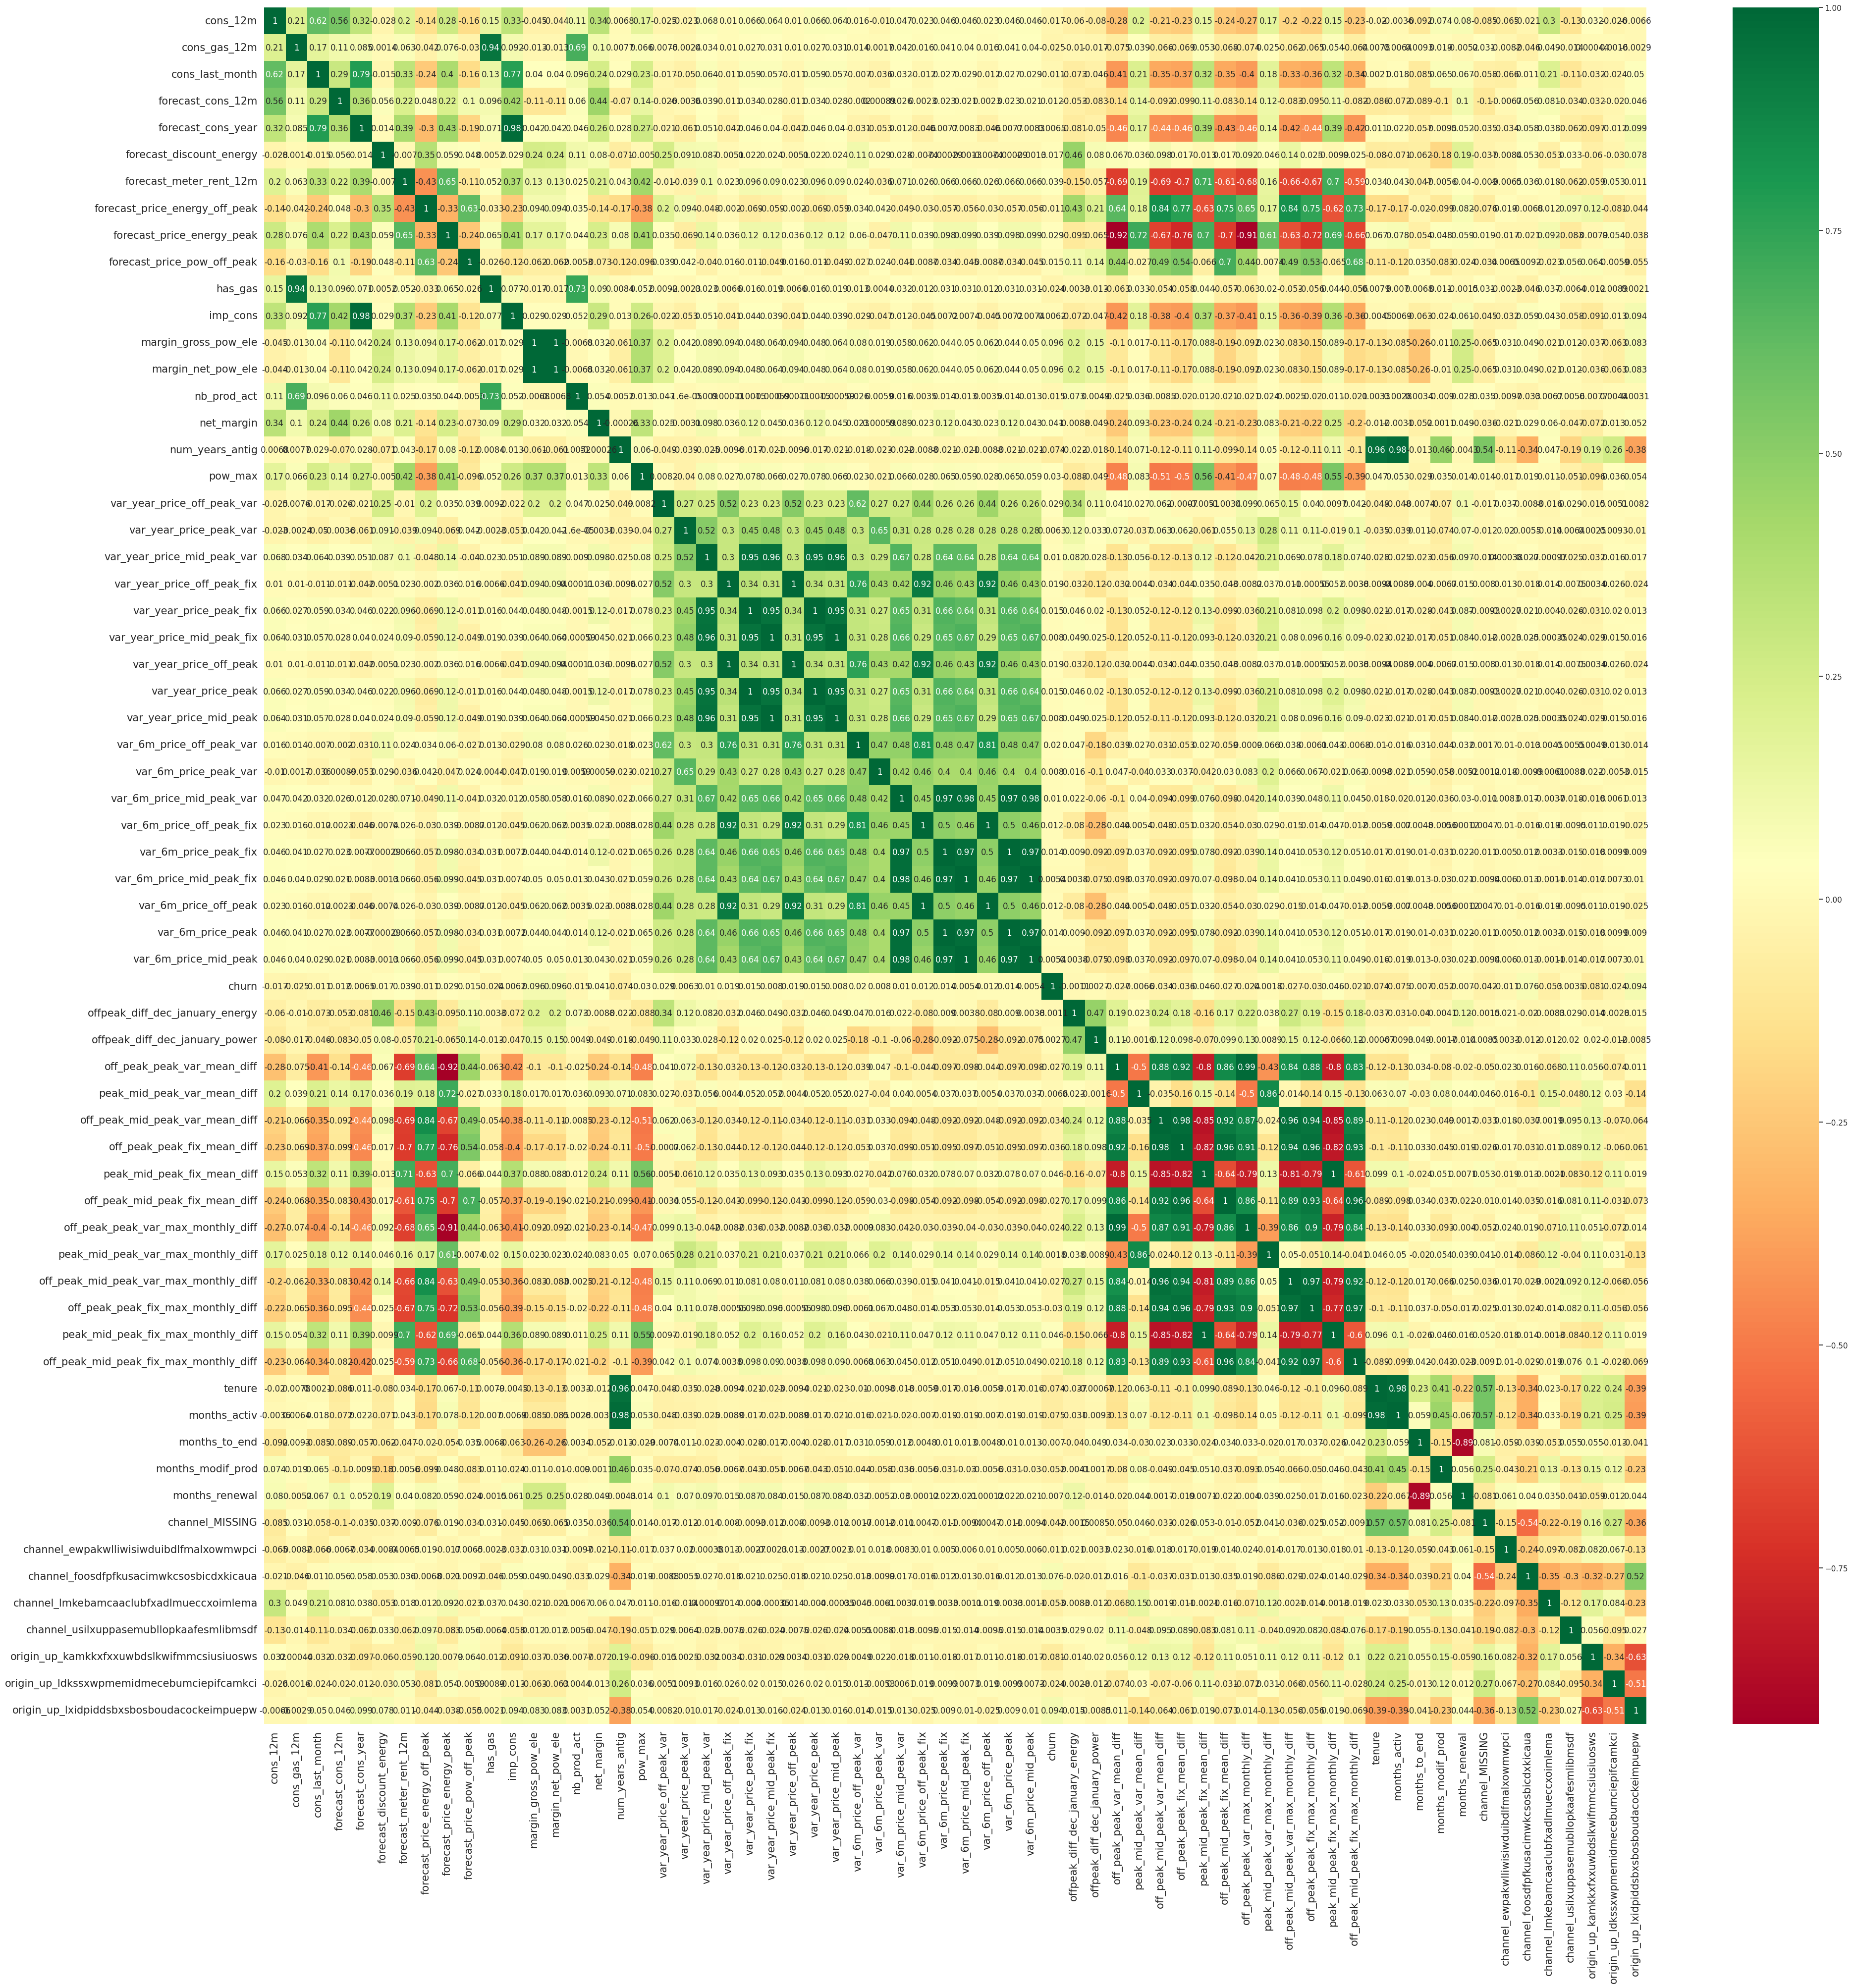

In [ ]:
# Correlation Heatmap

plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    annot_kws={'size': 12},
    cmap='RdYlGn'
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# View of graph
plt.show()


I will remove two variables(num_years_antig and forecast_cons_year) which exhibit a high correlation with other independent features

In [ ]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944         0.000000   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000         0.000000   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000         0.000000   
3  bba03439a292a1e166f80264c16191cb  3.200029      0.000000         0.000000   
4  149d57cf92fc41cf94415803a877cb4b  3.646011      0.000000         2.721811   

   forecast_cons_12m  forecast_discount_energy  forecast_meter_rent_12m  \
0           0.000000                       0.0                 0.444045   
1           2.280920                       0.0                 1.237292   
2           1.689841                       0.0                 1.599009   
3           2.382089                       0.0                 1.318689   
4           2.650065                       0.0                 2.122969   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114481                    0.098142   
1                        0.145711                    0.000000   
2                        0.165794                    0.087899   
3                        0.146694                    0.000000   
4                        0.116900                    0.100015   

   forecast_price_pow_off_peak  ...  months_modif_prod  months_renewal  \
0                    40.606701  ...                  2               7   
1                    44.311378  ...                 77               5   
2                    44.311378  ...                 69               9   
3                    44.311378  ...                 70              10   
4                    40.606701  ...                 72              10   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0            False                                     False   
1             True                                     False   
2            False                                     False   
3            False                                     False   
4             True                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   
3                                     False   
4                                     False   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                      True   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                        True  
1                                       False  
2                                       False  
3                                       False  
4                                       False  

[5 rows x 63 columns]

# Churn Model Prediction



In [ ]:
from pycaret.classification import setup, compare_models

# Assuming 'churn' is your target variable and 'df' is your pandas DataFrame
# You might want to drop the 'id' column as it's likely not a feature
df_model = df.drop(columns=['id'])

# Set up the PyCaret environment
# 'session_id' helps reproduce results
# 'numeric_features' can be used if you have specific numerical features to handle differently
setup(data=df_model, target='churn', session_id=123, numeric_features=['off_peak_peak_var_mean_diff', 'peak_mid_peak_var_mean_diff', 'off_peak_mid_peak_var_mean_diff', 'off_peak_peak_fix_mean_diff', 'peak_mid_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power'])

# Compare different classification models
best_model = compare_models()

# Print the best model found
print(best_model)

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [ ]:
from pycaret.classification import setup, compare_models,pull
results = pull()
top_5_models = results.sort_values(by='AUC', ascending=False).head(5)
print(top_5_models)

                                    Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.9064  0.6881  0.0857  0.6191   
gbc          Gradient Boosting Classifier    0.9023  0.6847  0.0131  0.3202   
rf               Random Forest Classifier    0.9067  0.6840  0.0534  0.8121   
xgboost         Extreme Gradient Boosting    0.9064  0.6692  0.1280  0.5704   
ada                  Ada Boost Classifier    0.9022  0.6621  0.0091  0.3983   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.1495  0.1298  0.2043     5.170  
gbc       0.0251  0.0192  0.0511     6.419  
rf        0.0989  0.0880  0.1890     2.946  
xgboost   0.2077  0.1796  0.2378     0.783  
ada       0.0176  0.0129  0.0455     1.254  


Models Considered:
1. Logistic Regression
2. Random Forest Classifier
3. Gradient Boosting
4. Support Vector Machine
5. KNN

### Model Selection Strategy:

Baseline Model: Start with Logistic Regression as a simple and interpretable baseline to set a benchmark for model performance.

Tree-Based Models: Explore Random Forest, Gradient Boosting, and XGBoost/LightGBM/CatBoost for capturing non-linearity and interactions well.

Complex Models: Consider neural networks for capturing intricate patterns if substantial data is available.

Ensemble Approaches: Build an ensemble model combining the strengths of different algorithms for improved predictive power.

### Model Evaluation Metrics:
Accuracy, Precision, Recall, F1-Score: Provide insights into model performance in predicting churn.

ROC-AUC (Receiver Operating Characteristic - Area Under the Curve): Measures the model's ability to distinguish between churn and non-churn instances.

Confusion Matrix: Provides a detailed breakdown of true positive, true negative, false positive, and false negative predictions.

Split the Data We need to split the dataset into training dataset and testing dataset. We will use train_test_slit from sklearn package to split the data into 70% for training and hold back 30% for testing.

In [ ]:
train_df = df.copy()

# Separate target variable from independent variables
X = df.drop(columns= ['id', 'churn'])
y = df['churn']

In [ ]:
X

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0      0.000000      4.739944         0.000000           0.000000   
1      3.668479      0.000000         0.000000           2.280920   
2      2.736397      0.000000         0.000000           1.689841   
3      3.200029      0.000000         0.000000           2.382089   
4      3.646011      0.000000         2.721811           2.650065   
...         ...           ...              ...                ...   
14601  4.508812      4.680707         0.000000           3.667360   
14602  3.858778      0.000000         2.260071           2.801191   
14603  3.265996      0.000000         2.255273           2.281919   
14604  2.120574      0.000000         0.000000           1.308351   
14605  3.941064      0.000000         0.000000           2.882758   

       forecast_discount_energy  forecast_meter_rent_12m  \
0                           0.0                 0.444045   
1                           0.0                 1.237292   
2                           0.0                 1.599009   
3                           0.0                 1.318689   
4                           0.0                 2.122969   
...                         ...                      ...   
14601                       0.0                 1.291591   
14602                       0.0                 2.161458   
14603                       0.0                 2.115943   
14604                       0.0                 0.912753   
14605                       0.0                 0.315970   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                            0.114481                    0.098142   
1                            0.145711                    0.000000   
2                            0.165794                    0.087899   
3                            0.146694                    0.000000   
4                            0.116900                    0.100015   
...                               ...                         ...   
14601                        0.138305                    0.000000   
14602                        0.100167                    0.091892   
14603                        0.116900                    0.100015   
14604                        0.145711                    0.000000   
14605                        0.167086                    0.088454   

       forecast_price_pow_off_peak  has_gas  ...  months_modif_prod  \
0                        40.606701        1  ...                  2   
1                        44.311378        0  ...                 77   
2                        44.311378        0  ...                 69   
3                        44.311378        0  ...                 70   
4                        40.606701        0  ...                 72   
...                            ...      ...  ...                ...   
14601                    44.311378        1  ...                  8   
14602                    58.995952        0  ...                 41   
14603                    40.606701        0  ...                 47   
14604                    44.311378        0  ...                 41   
14605                    45.311378        0  ...                 73   

       months_renewal  channel_MISSING  \
0                   7            False   
1                   5             True   
2                   9            False   
3                  10            False   
4                  10             True   
...               ...              ...   
14601              20            False   
14602               5            False   
14603              11            False   
14604               5            False   
14605               1             True   

       channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4              

In [ ]:
y

0        1
1        0
2        0
3        0
4        0
        ..
14601    0
14602    1
14603    1
14604    0
14605    0
Name: churn, Length: 14606, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state=42)
print('Training cases: %d\n Test cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 10224
 Test cases: 4382


In [ ]:
y.value_counts()

churn
0    13187
1     1419
Name: count, dtype: int64

We can see that the number of churn and not churn is imbalanced. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique to solve the this problem

In [ ]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE().fit_resample(X, y)

In [ ]:
#check the number of target variable after oversampling using SMOTE
from collections import Counter
print('Resample dataset shape', Counter(y))

Resample dataset shape Counter({1: 13187, 0: 13187})


Resample dataset shape Counter({1: 13186, 0: 13186}) It can be seen that the distrubtion of Churn status are now balanced

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10224, 61)
(10224,)
(4382, 61)
(4382,)


## Logistics Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print (model)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [ ]:
#Let's check the accuracy of the predictions
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.8986764034687358


Text(168.97222222222223, 0.5, 'Actual')

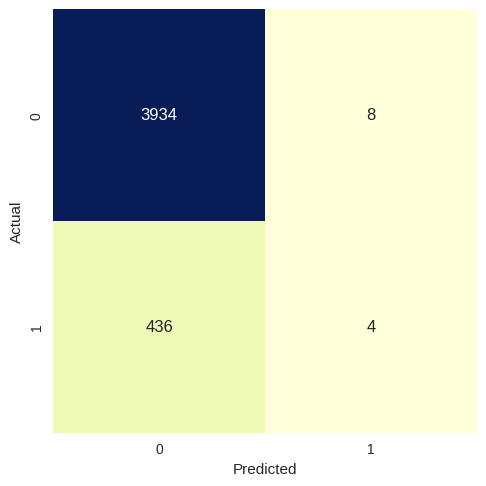

In [ ]:
#create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, cbar=False,  cmap="YlGnBu" ,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
from sklearn import metrics
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 4
False positives: 8
True negatives: 3934
False negatives: 436



In [ ]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3942
           1       0.33      0.01      0.02       440

    accuracy                           0.90      4382
   macro avg       0.62      0.50      0.48      4382
weighted avg       0.84      0.90      0.85      4382



**Interpretation:**

For class 0 (churn = 0), the model performs well with high precision, recall, and F1-score, indicating strong predictive performance.

For class 1, the model has very low recall (only correctly identifying 1% of actual positives), which significantly impacts precision and F1-score.

The overall accuracy is relatively high (91%), but due to imbalanced classes, accuracy might not be the most informative metric.

The macro-average and weighted-average metrics provide an overall picture considering both classes, showing the weighted average performs better, given the class imbalance.

Given the imbalance, it might be essential to consider other metrics like precision-recall curves, ROC-AUC, or focus on class-specific evaluation to better understand the model's performance, especially regarding its ability to identify the minority class (class 1).

In [ ]:
# retrieve the precision_score and recall_score metrics
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, y_pred))
print("Overall Recall:",recall_score(y_test, y_pred))

Overall Precision: 0.3333333333333333
Overall Recall: 0.00909090909090909


These overall metrics are likely calculated by aggregating the precision and recall values across multiple classes or predictions. It appears that the model's performance, when averaged across all classes or predictions, yields a low recall of approximately 0.90% and a precision of 33%.

However, in scenarios with class imbalance or when considering multiple classes, such aggregated metrics might not accurately represent the model's performance. It's often beneficial to examine class-specific metrics or use weighted averages, especially when dealing with imbalanced datasets, to get a more informative evaluation of the model's behavior across different classes.

Until now, we've considered the predictions from the model as being either 1 or 0 class labels. Actually, things are a little more complex than that. Statistical machine learning algorithms, like logistic regression, are based on probability; so what actually gets predicted by a binary classifier is the probability that the label is true (P(y)) and the probability that the label is false (1 - P(y)). A threshold value of 0.5 is used to decide whether the predicted label is a 1 (P(y) > 0.5) or a 0 (P(y) <= 0.5). You can use the predict_proba method to see the probability pairs for each case:

In [ ]:
y_scores = model.predict_proba(X_test)
print(y_scores[:10])

[[0.9251849  0.0748151 ]
 [0.91394488 0.08605512]
 [0.91351452 0.08648548]
 [0.86925375 0.13074625]
 [0.87881261 0.12118739]
 [0.90051759 0.09948241]
 [0.91567703 0.08432297]
 [0.94948546 0.05051454]
 [0.92239619 0.07760381]
 [0.95562888 0.04437112]]


The decision to score a prediction as a 1 or a 0 depends on the threshold to which the predicted probabilities are compared. If we were to change the threshold, it would affect the predictions; and therefore change the metrics in the confusion matrix. A common way to evaluate a classifier is to examine the true positive rate (which is another name for recall) and the false positive rate for a range of possible thresholds. These rates are then plotted against all possible thresholds to form a chart known as a received operator characteristic (ROC) chart, like this:

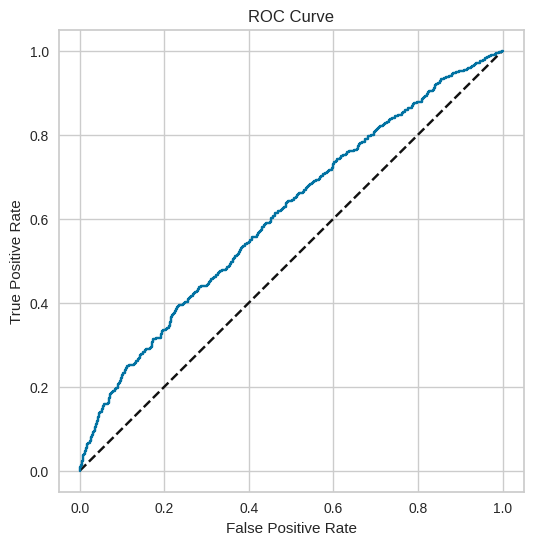

In [ ]:
from sklearn.metrics import roc_curve
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC chart shows the curve of the true and false positive rates for different threshold values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the chart represents the probability of predicting correctly with a 50/50 random prediction; so you obviously want the curve to be higher than that (or your model is no better than simply guessing!).

The area under the curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model. Once again, scikit-Learn includes a function to calculate this metric.

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.6082572298325722


Looking at the true negatives, we have 3981 out of 3989. This means that out of all the negative cases (churn = 0), we predicted 3981 as negative (hence the name True negative). This is great!

Looking at the false negatives, this is where we have predicted a client to not churn (churn = 0) when in fact they did churn (churn = 1). This number is too high at 390, but we want to get the false negatives to as close to 0 as we can.

Looking at false positives, this is where we have predicted a client to churn when they actually didnt churn. For this value we can see there are 8, quite good.

With the true positives, we can see that in total we have 393 clients that churned in the test dataset. However, we are only able to correctly identify 3 of those 393, which is very poor.

Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.

Looking at the precision score and recall score, this shows us a score of 0.27 and 0.02 which are very bad. This is not a good model.

AS we have seen logistic regression dosnot fit properly so, we move on next algorithm i.e, Random Forest

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators = 1000).fit(X_train, (y_train))
print (model_RF)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=1000, n_jobs=None,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


True positives: 20
False positives: 5
True negatives: 3937
False negatives: 420

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3942
           1       0.80      0.05      0.09       440

    accuracy                           0.90      4382
   macro avg       0.85      0.52      0.52      4382
weighted avg       0.89      0.90      0.86      4382

Accuracy: 0.9030123231401187
Overall Precision: 0.8
Overall Recall: 0.045454545454545456

AUC: 0.6543825815229924


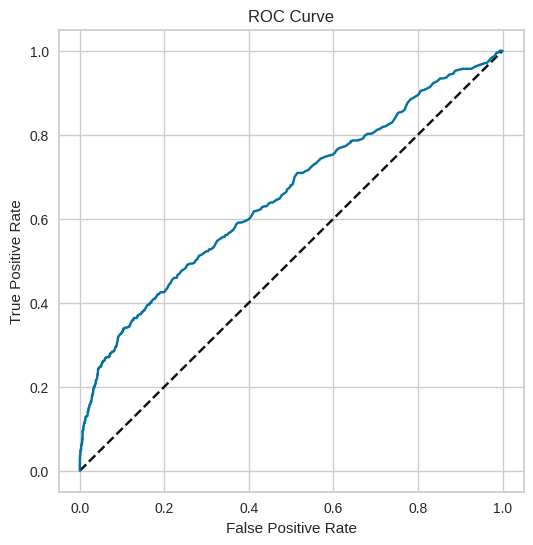

In [ ]:
y_pred_RF = model_RF.predict(X_test)
y_scores_RF = model_RF.predict_proba(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_RF).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(classification_report(y_test, y_pred_RF))

print('Accuracy:', accuracy_score(y_test, y_pred_RF))
print("Overall Precision:",precision_score(y_test, y_pred_RF))
print("Overall Recall:",recall_score(y_test, y_pred_RF))
auc = roc_auc_score(y_test,y_scores_RF[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores_RF[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Looking at the true negatives, we have 3937 out of 3989. This is great!

Looking at the false negatives, 420 is too high but better than Logistic Model.

Looking at false positives, we can see there are only , quite good.

With the true positives, we correctly identify 20 of those 393, which is very poor.

Looking at the accuracy score, this is very misleading, looking at the precision score and recall score, this shows us a score of 0.81 which is not bad, but could be improved. However, the recall shows us that the classifier has a very poor ability to identify positive samples. This would be the main concern for improving this model!

The AUC is better a little bit comparing with Logistic Regression.

In [ ]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_RF.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

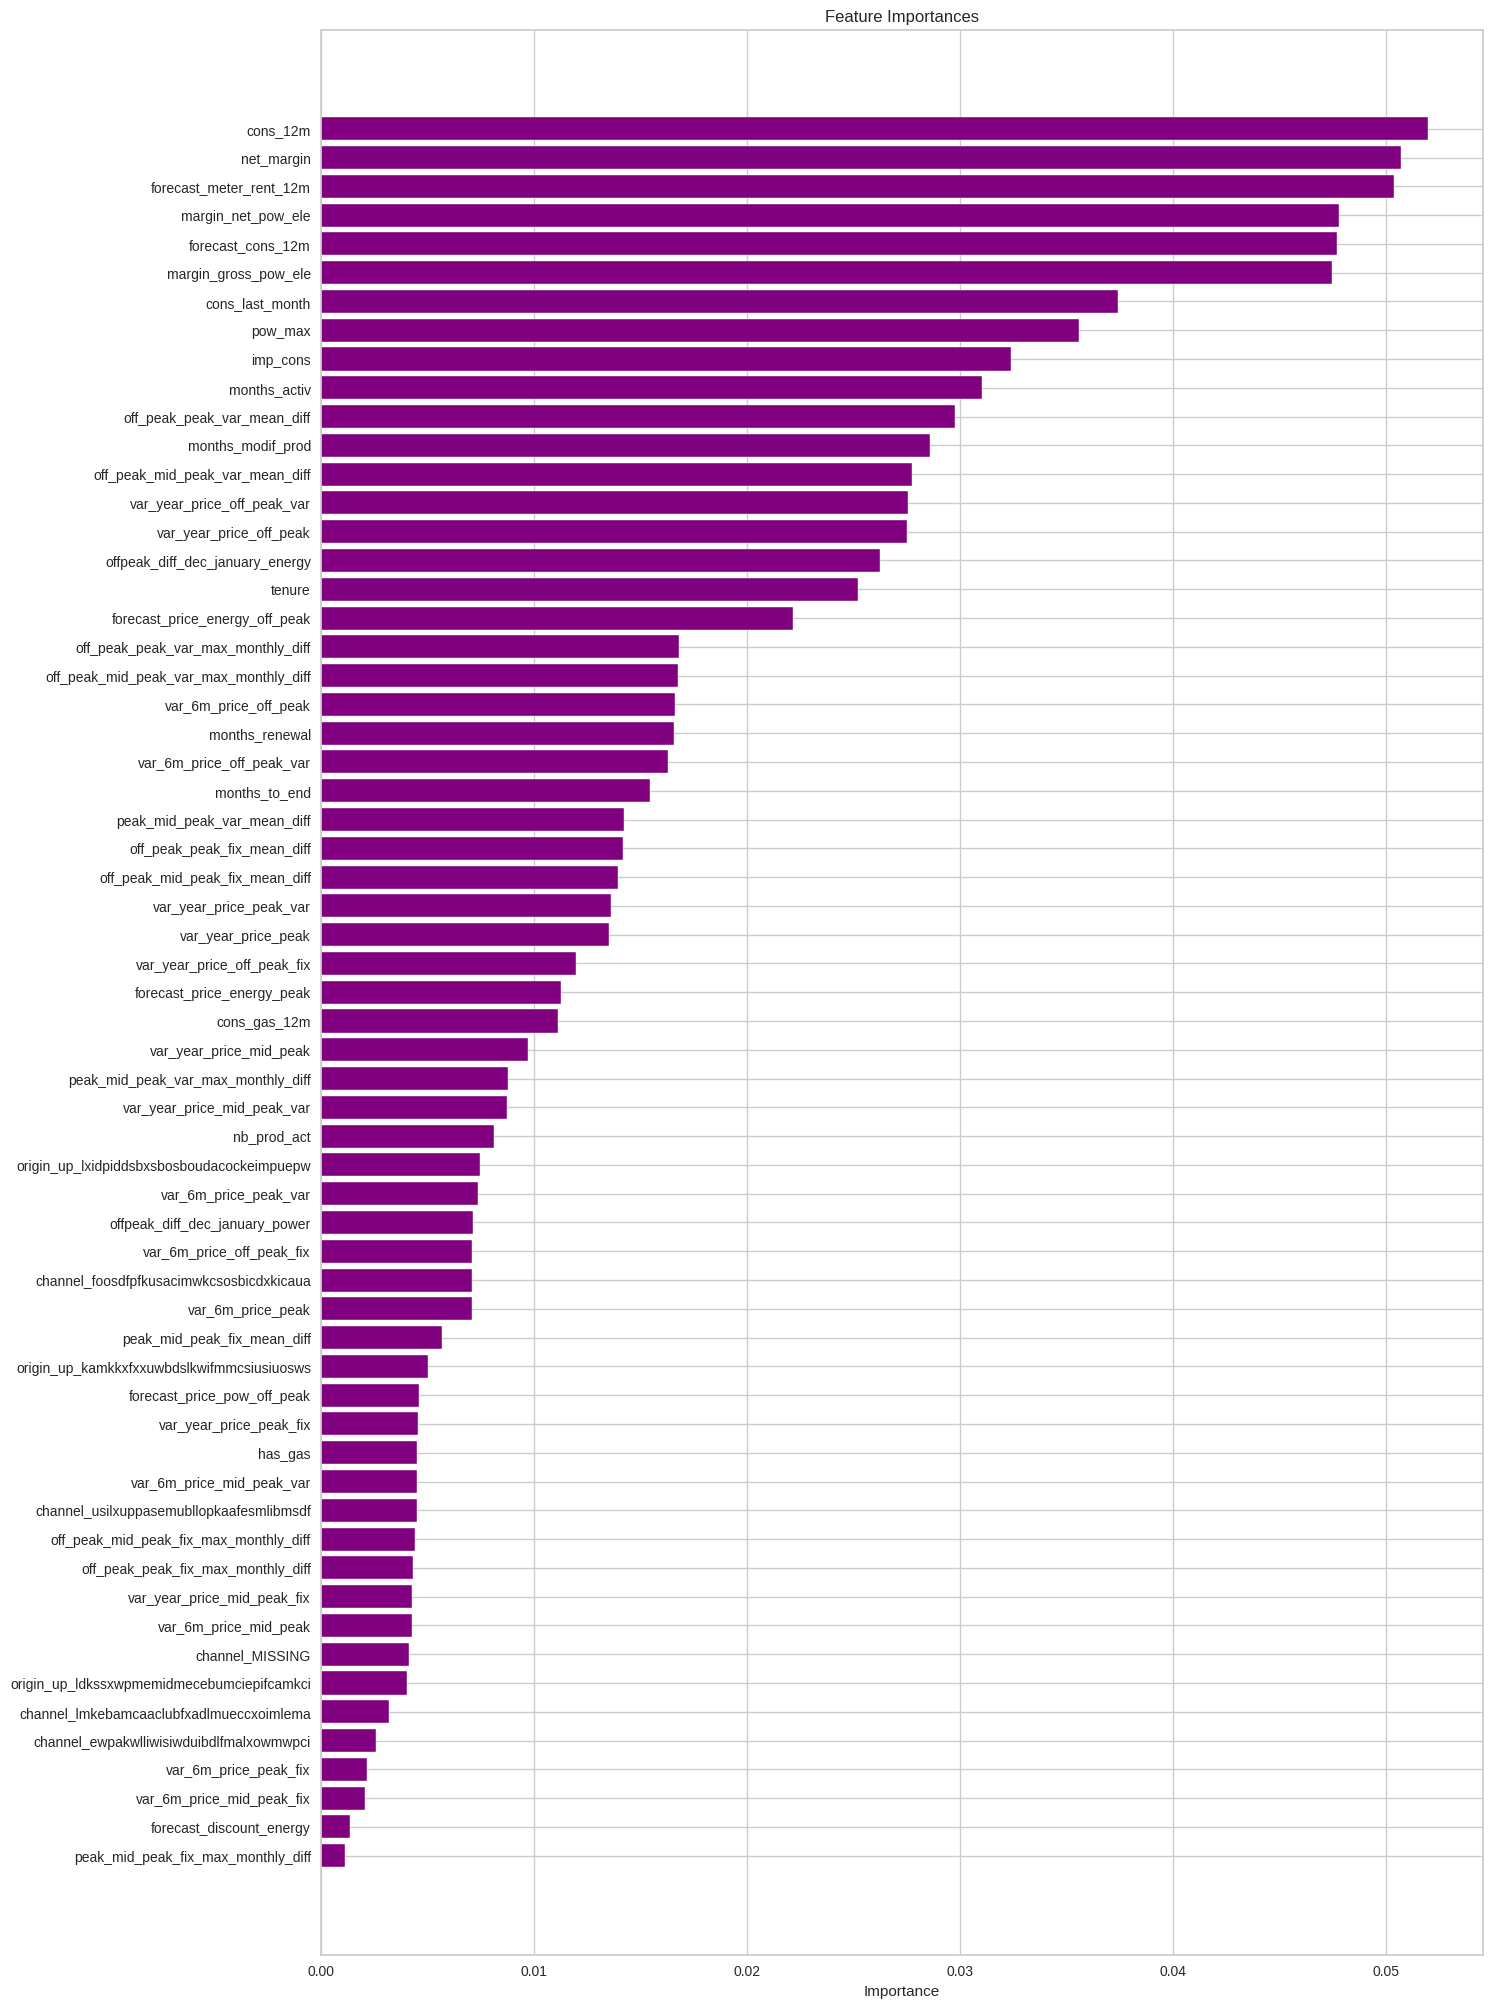

In [ ]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='purple', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:

Forecast_meter_rent,Net margin and consumption over 12 months is a top driver for churn in this model

Margin on power subscription also is an influential driver

Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract

The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it

Our price sensitivity features are scattered around but are not the main driver for a customer churning

The last observation is important because this relates back to our original hypothesis:

Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [ ]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [ ]:
y_scores = model_RF.predict_proba(X_test)
probabilities = y_scores[:, 1]

In [ ]:
X_test['churn'] = y_pred_RF.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('data_with_predictions.csv')

In [ ]:
import joblib

# Save the model as a pickle file
filename = 'powerco_churn_model.pkl'
joblib.dump(model_RF, filename)

['powerco_churn_model.pkl']

**Business impact of discount**

We conduct a brief analysis on the discount strategy proposed. This is just 1 way to solve it, there may be many other ways!

The SME division head proposed that we give a 20% discount to high propensity to churn customers. We can assume to start that everyone who is offered a discount will accept it.

**Workflow**

Our task is to calculate the forecast revenue for the set of customers:

When no discount is offered

And when a discount is offered based on a probability cutoff to decide who should receive the 20% discount

And hence to decide where the cut-off should be set in order to maximise revenue

In [ ]:
test_data = pd.read_csv('data_with_predictions.csv')
test_data.drop(test_data.columns[0], axis=1, inplace=True)
test_data.head()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0  4.173390      4.193598         3.165541           3.168368   
1  4.075036      0.000000         3.003461           3.305998   
2  3.848435      0.000000         0.000000           2.756568   
3  4.345433      0.000000         0.000000           3.516690   
4  4.185655      0.000000         3.355834           3.208148   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                 2.073828   
1                      30.0                 1.255031   
2                       0.0                 1.289366   
3                       0.0                 1.304921   
4                       0.0                 2.123067   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114667                    0.099548   
1                        0.198096                    0.000000   
2                        0.141434                    0.000000   
3                        0.142996                    0.000000   
4                        0.120372                    0.103487   

   forecast_price_pow_off_peak  has_gas  ...  channel_MISSING  \
0                    40.606701        1  ...            False   
1                    46.305378        0  ...            False   
2                    44.311378        0  ...            False   
3                    44.311378        0  ...            False   
4                    40.606701        0  ...            False   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                      True   
2                                      True   
3                                      True   
4                                      True   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                        True   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  churn  churn_probability  
0                                        True      0              0.104  
1                                        True      0              0.146  
2                                        True      0              0.032  
3                                        True      0              0.085  
4                                       False      0              0.059  

[5 rows x 63 columns]

Calculating a baseline revenue estimate (no intervention)
Calculate a baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecast price and actual churn outcome. Call this basecase_revenue.

For customers who end up churning, we should reduce our forecast revenue calculation by 91.9% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year). Call this new variable basecase_revenue_after_churn, ie basecase_revenue_after_churn = basecase_revenue(1 -0.919 churn)

In [ ]:
# Electricity revenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more data)
# Note that we need to reverse the log10-transformation from the data cleaning step

test_data['basecase_revenue'] = (np.power(10, test_data['forecast_cons_12m']) + 1) * test_data['forecast_price_energy_off_peak'] + test_data['forecast_meter_rent_12m']

# Taking churn into account
test_data['basecase_revenue_after_churn'] = test_data['basecase_revenue'] * (1 - 0.919 * test_data['churn'])

In [ ]:
test_data.head()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0  4.173390      4.193598         3.165541           3.168368   
1  4.075036      0.000000         3.003461           3.305998   
2  3.848435      0.000000         0.000000           2.756568   
3  4.345433      0.000000         0.000000           3.516690   
4  4.185655      0.000000         3.355834           3.208148   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                 2.073828   
1                      30.0                 1.255031   
2                       0.0                 1.289366   
3                       0.0                 1.304921   
4                       0.0                 2.123067   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114667                    0.099548   
1                        0.198096                    0.000000   
2                        0.141434                    0.000000   
3                        0.142996                    0.000000   
4                        0.120372                    0.103487   

   forecast_price_pow_off_peak  has_gas  ...  \
0                    40.606701        1  ...   
1                    46.305378        0  ...   
2                    44.311378        0  ...   
3                    44.311378        0  ...   
4                    40.606701        0  ...   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                      True   
2                                      True   
3                                      True   
4                                      True   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                        True   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  churn  churn_probability  \
0                                        True      0              0.104   
1                                        True      0              0.146   
2                                        True      0              0.032   
3                                        True      0              0.085   
4                                       False      0              0.059   

   basecase_revenue  basecase_revenue_after_churn  
0        171.157200                    171.157200  
1        402.203316                    402.203316  
2         82.176885                     82.176885  
3        471.357082                    471.357082  
4        196.633386                    196.633386  

[5 rows x 65 columns]

Calculate the estimated benefits and costs of intervention
Now, pick a cut-off probability (eg 0.5) so that:

Customers with a higher churn probability than the cut-off get a discount, and
Customers below the churn-probability do not get a discount.
From this, calculate the revenue of the intervention scenario assuming:

All customers who are offered a discount accept it

Customers who do receive a discount are are assumed not to churn in the next twelve months (ie churn probability = 0), and therefore the retained revenue is 0.8basecase_revenue , being (1-discount_fraction)basecase_revenue

Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actually churned or not).

Now, map out the revenue delta as a function of the cut-off probability in a graph. What cut-off probability approximately optimises the revenue outcome? Assume for these calculations that the customer does not consume more or less electricity because the price changes. In practice, we would expect that if the customer's cost goes down then their consumption might increase. We will see two counterbalancing effects at play:

For true positives we will see revenue retention vs the no-discount scenario
For false positives we will see reduced revenue from giving them a discount when they wouldn't in fact churn. (False negatives represent an opportunity cost but not an actual cost difference between the two scenarios.)
The optimal cut-off point will balance the benefits from true positives against the costs of false positives. Our task is to approximately find the optimal cut-off point. We may need to make additional assumptions. If we feel the assumptions above aren't justified and that others are better then we should modify our assumptions.

In [ ]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2) -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['churn_probability'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

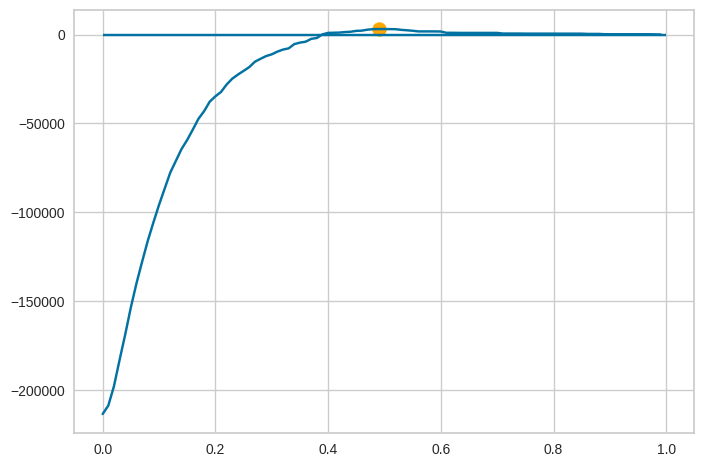

Maximum benefit at cutoff 0.49 with revenue delta of $3,083.64


In [ ]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_data, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})

def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='orange')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

plot_tradeoff(rev_deltas)

**Optional extra: how to select the cut-off?**

Above, we decided who to offer the discount to based on a probability cut-off. Is this the optimal strategy?

For instance, we might be offering discounts to customers who are not very profitable, thus worsening our overall margins substantially. For example, if offering a discount makes the customer unprofitable on a net margin basis then we might want to let them churn rather than save them.

Even if we only consider revenue, this strategy might not be optimal from a revenue viewpoint. For instance, we can calculate the expected revenue impact of our strategy and prioritise customers for discounts that have a high expected revenue impact. (This means that the probability of churn might be high but they also might be valuable customers).

A general principle here is that we can afford to spend more on retaining high-value customers because the costs of losing them are higher. A very common mistake in business applications of churn is to focus on the churn probability whilst forgetting the value impact (to greater or lesser extents). We have seen many cases where our clients spend as much effort on retaining unprofitable customers as they do on retaining highly profitable customers.

In [ ]:
def get_rev_delta_high_value(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2, min_rev: float=500):
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff and rev
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given for high-value customers => customer stays for full year, independent
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[(pred['churn_probability'] >= cutoff) & (pred['basecase_revenue'] > min_rev),
    'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

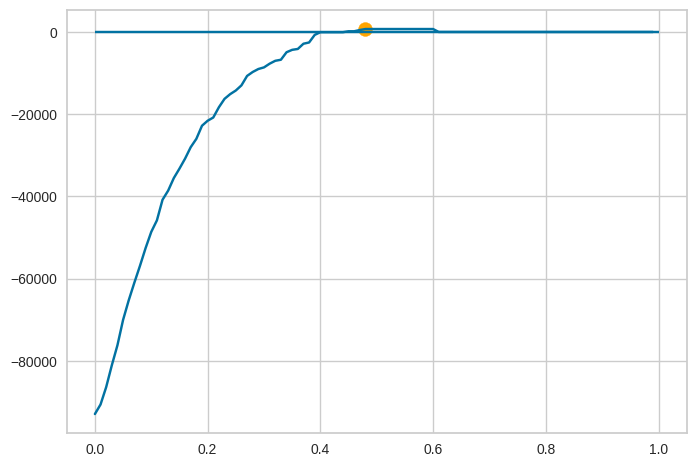

Maximum benefit at cutoff 0.48 with revenue delta of $716.31


In [ ]:
## Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(test_data, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
plot_tradeoff(rev_deltas_high_value)

## Note:
In this case, it doesn't make sense to prioritize large-revenue customers, since the overall revenue delta is much lower than when targeting everyone. However, this is only the case here since the intervention doesn't depend on the number of customers (simply adjusting prices). The interventions usually go beyond simply adjusting prices to prevent churn.

There may be the option of intensifying the customer relation, adding key account managers, or other interventions that do incur costs depending on how many customers are targeted. In that case, it may be benefitial to target only a subset of customers to save on these costs, even if the delta in the figure above is reduced.

## Optional extra: Using forecast rather than actual churn
We may have noticed above that we used actual churn outcomes in calculating the financial impact. Actual churn outcomes are fine if we know them and are conducting a retrospective analysis of the effectiveness of a strategy. This example of analysis is commonly known as "backtesting", ie seeing how well a strategy would have performed historically.


Of course, one must be careful that any analysis is done using out-of-sample data. Conducting the analysis on the training data will lead to predictions that are too optimistic.

In practice, actual outcomes may not be available because they are in the future. An alternative is to optimise predicted/forecast revenue based on the probabilities which are an output from our churn model. In this case, we would replace the actual churn outcomes (churn) with the predicted probability of churn from our model. The results here are obviously model-dependent.

If our model probabilities are poorly calibrated then we can end up with quite poor results from this. Going down this path therefore usually requires the extra step of checking how well calibrated the model probabilities are, and potentially correcting for any miscalibration using Platt scaling, sigmoid calibration or isotonic regression.

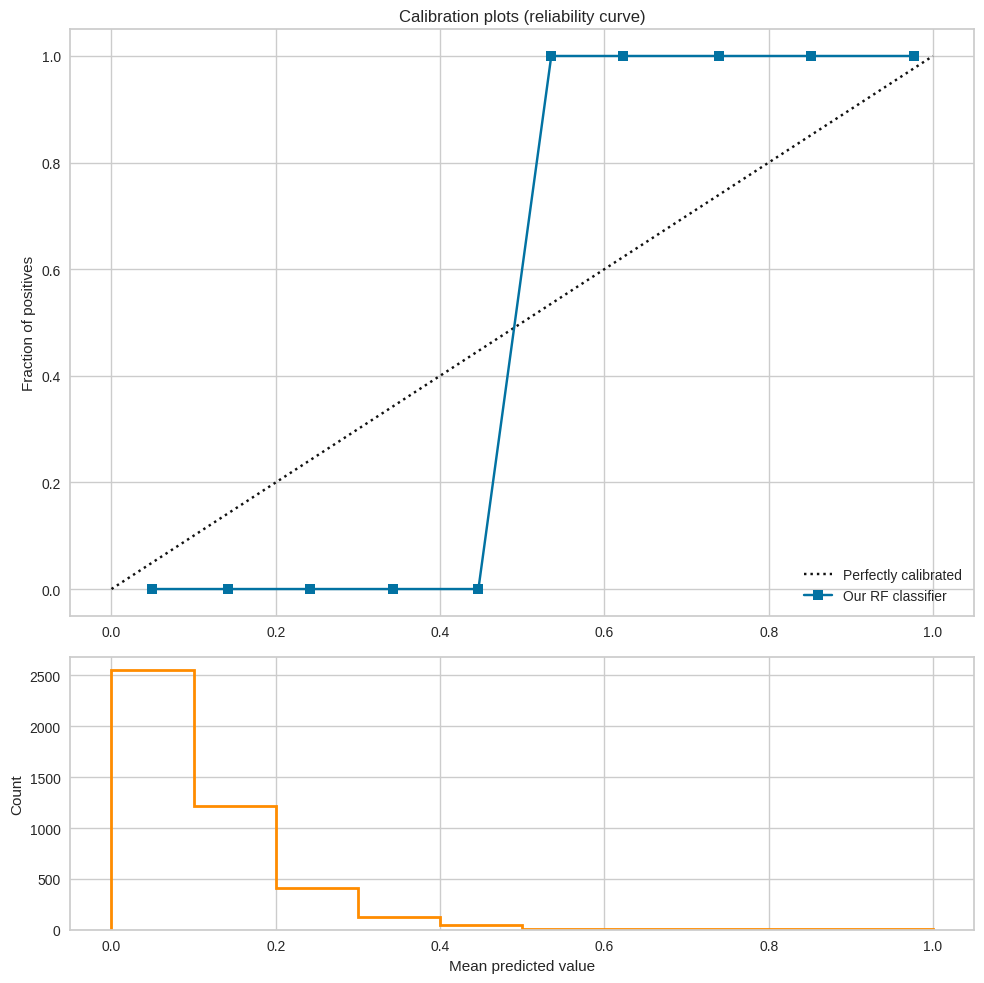

In [ ]:
# Check our calibration

from sklearn.calibration import calibration_curve

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true=test_data['churn'],
    y_prob=test_data['churn_probability'],
    n_bins=10
)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Our RF classifier")
ax2.hist(test_data['churn_probability'], range=(0, 1), bins=10, color='darkorange', histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
plt.tight_layout()

This chart tells us a few things:

The top calibration curve exhibits a sigmoid curve, which is typical for an under-confident classifier.
The bottom chart shows us that the model is postively skewed toward predicting a probability, perhaps due to having such low confidence.

In [ ]:
# Electricity evenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more d
# Note that we need to reverse the log10-transformation from the data cleaning step

test_data['basecase_revenue'] = np.power(10, test_data['forecast_cons_12m']) * test_data['forecast_price_energy_off_peak'] + test_data['forecast_meter_rent_12m']
# Taking churn into account
test_data['basecase_revenue_after_churn'] = test_data['basecase_revenue'] * (1 - 0.919 * test_data['churn_probability'])

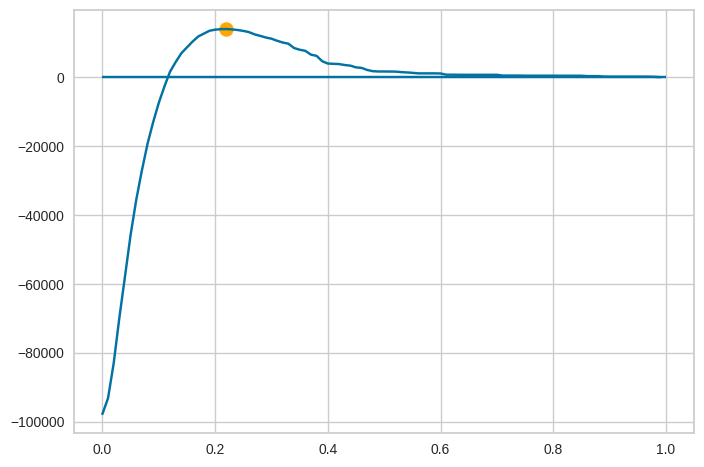

Maximum benefit at cutoff 0.22 with revenue delta of $13,974.12


In [ ]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_data, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
plot_tradeoff(rev_deltas)